## Energy Consumption Forecasting

Dataset analysis report and modelling. Built as part of the hard skill test for a position as Data Scientist.

Developed by Gabriel Ribeiro Gomes. *ribeiroggabriel@gmail.com*.

---

_Obs_: The timebox of development of this notebook was 6 hours. I'll be focusing on working code readability and proposing a good model and insights. As I do value the writing on my notebooks, I'll be making markdown-heavy annotations before most of the cells. I'll probably not have time to review the markdowns, so, please, disregard any typing errors, formatting errors or wrong verb conjugations, thanks!

### Case analysis

In the field of electricity, we have lots of companies, most of which are energy distributors. Thus, an important problem is to be able to **predict energy consumption** in specific locations, thus ensuring a quality service for our customers, and without waste for the company.

From the attached dataset, we need to know the **energy consumption forecast for the next 4 hours**.

To develop this solution, we expect you to present a description of the data, a proposed solution for the prediction and a brief discussion of the results found. You must deliver everything in a PDF file with the code used, preferably in Python, comments and results.

### Project setup and folder reading

So, one of the first things we do when we start a project locally, is to make sure we'll develop in an independent space, without the influence of other already installed libraries or packages. One solution to avoid this is to create a virtual environment. I use the Anaconda distribution, that comes with the anaconda terminal and conda environments. To create and execute a new environment for this project, I'll just execute:

```conda create -n challenge-forecasting python=3.8``` and ```conda activate challenge-forecasting```

Not informing a python version will automatically setup this environment with the latest stable python version. Here, we use python 3.8 for compatibility with some packages.

Our folder will have the following structure:

```
 root_folder/
     |_ Energy Consumption Forecasting.ipynb
     |_ data.csv
     |_ requirements.txt
```
Then, we can install our packages with the ```pip install -r requirements.txt``` command, on the ```root_folder```. With those parts set up, we can use the ```jupyter notebook``` command on the terminal and start our code.

---

We'll use the ```glob``` module to read all archives on the folder that ends with the format ```*.csv``` in an automatized way, returning them in a list.

In [1]:
# To make the code cells visualization more clean, we're supressing the warnings
import warnings
warnings.filterwarnings("ignore")

# To find the '*.csv' file using the system package 'glob'
import glob
list_of_folders_csv_files = glob.glob('*.csv')
print("List of all .csv files in the folder:", list_of_folders_csv_files)

List of all .csv files in the folder: ['data.csv']


We can see that our list has only one file on it, that is our interest file. We'll store it in a interest variable to manipulate it in the data wrangling step of our analysis.

In [2]:
# Our .csv of interest is the first (and only one) on the list
interest_csv = list_of_folders_csv_files[0]
print("Our interest .csv file:", interest_csv)

Our interest .csv file: data.csv


This is a nice process that I usually do anytime I have to access multiple files in a folder, avoiding problems with paths and names that are too long to fit in a readable code.

In this way, we store our files paths in variables with verbose names, indicating each one of them, and modularizing our reading process.

### Initial dataset intuition

In this portion of the notebook we'll have our initial intuition about the dataset, perform our data wrangling process and prepare the dataset to our exploratory data analysis and modelling.

What we'll be doing:
* Importing the dataset and printing the first records with the ```.head()``` method.
* How many lines and columns the dataset has using the ```.shape``` property.
* Use the ```.info()``` method to:
    * See the variables types.
    * See if there's any missing values.
    * Start to think about new features and data types castings.
    
---

We'll import standard libraries and assign to the default variable ```df```. Using the method ```read_csv()``` from the pandas library, we see that the default separator ```","``` does not fit the data pattern, that uses the separator ```";"``` passing ```sep=";"```. Then, we'll see the first ten records.

In [3]:
import numpy as np
import pandas as pd

df = pd.read_csv(interest_csv, sep=';')
df.head(10)

,Data,Hora,Consumo
0,01/01/2019,00:00,"27399,64"
1,01/01/2019,01:00,"26012,17"
2,01/01/2019,02:00,"24548,73"
3,01/01/2019,03:00,"23446,89"
4,01/01/2019,04:00,"22850,35"
5,01/01/2019,05:00,"22714,09"
6,01/01/2019,06:00,"23106,73"
7,01/01/2019,07:00,"23575,76"
8,01/01/2019,08:00,"23897,07"
9,01/01/2019,09:00,"25485,70"


Now, let's check the shape of our data.

In [4]:
print(f"The number of lines in this dataset is: {df.shape[0]} lines")
print(f"The number of columns in this dataset is: {df.shape[1]} columns")

The number of lines in this dataset is: 13872 lines
The number of columns in this dataset is: 3 columns


And to finish, see some information about it.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13872 entries, 0 to 13871
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Data     13872 non-null  object
 1   Hora     13872 non-null  object
 2   Consumo  13872 non-null  object
dtypes: object(3)
memory usage: 325.2+ KB


We can see that all columns have the same ammount of "Non-Null" data, corresponding to the number of entries (both 13872) which tells us our dataset doesn't have ```NaN``` values. All of our variables are objects, in this case, strings. By seeing the data and aligning it with the business intuituion, we have a date, represented by the column "Data", a hour, represented by the column "Hora", and a energy consumption/demand value, probably in kWh (kilowatts per hour) and represented by the column "Consumo".

With this first analysis, we can now start to make some changes and data prep to make our data suitable for a time series analysis.

### Convertions and data preparation

The first feature engineering this dataset needs is a datetime column that has the ```datetime64[ns]``` type, and then we'll make it our index. We can create this datetime column by feature engineering the "Data" and "Hora" columns.

In [6]:
df['datetime'] = df['Data'] + ' ' + df['Hora']
df['datetime'] = pd.to_datetime(df['datetime'], format = '%d/%m/%Y %H:%M')
df.set_index('datetime', drop = True, inplace =True)
df.head()

,Data,Hora,Consumo
datetime,,,
2019-01-01 00:00:00,01/01/2019,00:00,"27399,64"
2019-01-01 01:00:00,01/01/2019,01:00,"26012,17"
2019-01-01 02:00:00,01/01/2019,02:00,"24548,73"
2019-01-01 03:00:00,01/01/2019,03:00,"23446,89"
2019-01-01 04:00:00,01/01/2019,04:00,"22850,35"


Now, we'll change the type on the "Consumo" column. Seeing that our string object has a ```","``` as separator, which is a brazilian pattern for numeric representation, we'll first need to replace the comma with a point, to make the casting to ```float``` possible.

We'll make a security check if we need to debug this cell by assuring that the operation will only be executed if the current type is different from our target type, that is ```float```.

Then, we'll see the ```.info()``` method again.

In [7]:
if type(df.Consumo.iloc[0]) != np.float64:
    df["Consumo"]= df["Consumo"].str.replace(",",".").astype("float")

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13872 entries, 2019-01-01 00:00:00 to 2020-07-31 23:00:00
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Data     13872 non-null  object 
 1   Hora     13872 non-null  object 
 2   Consumo  13872 non-null  float64
dtypes: float64(1), object(2)
memory usage: 433.5+ KB


With this, we can now safely drop the columns "Data" and "Hora". We can also rename "Consumo" to "value" to follow the pattern of lowercase named-in-english columns. Then, we'll have a final look at our dataset.

This is other cell that need a security check for debug. Because we change the columns names all at once, we can use only one of them as our parameter for the security condition (we'll use "Data"). Then, if the column still exists on the dataset, it will drop all columns that we've already decided to drop, and change names of the remaining ones.

In [8]:
if 'Data' in df.columns:
    df.drop(columns=['Data', 'Hora'], inplace = True)
    df.rename(columns={'Consumo':'value'}, inplace = True)
    
df.head()

,value
datetime,
2019-01-01 00:00:00,27399.64
2019-01-01 01:00:00,26012.17
2019-01-01 02:00:00,24548.73
2019-01-01 03:00:00,23446.89
2019-01-01 04:00:00,22850.35


So, we've finished our data wrangling process. Other thing that we've noticed is that our data is probably hourly stamped, but we can double-check it by code in the analysis section. 

To close this section, let's take an initial look at our data using the ```.plot()``` method. We'll plot:

* The raw data.
* The 7-days moving average (ma) of the data.
    * The intuition behind the moving average plot is to see some trend and seasonality behaviour.

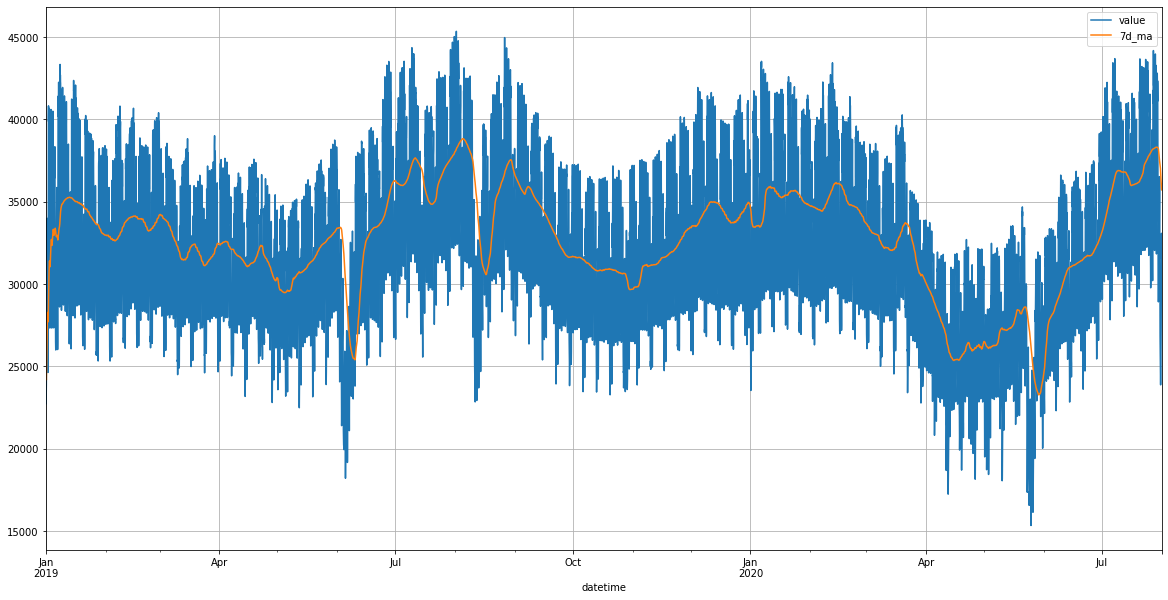

In [9]:
df_plot = df.copy()
df_plot['7d_ma'] = df_plot.value.rolling('7d').mean()
df_plot.plot(figsize=(20,10), grid="on");

This first visualization of the data points and the 7-days moving average gives us a great intuition about the existence of a seasonality.

**About the visualization**: Data visualization is one of the most important skills when developing a EDA. For this specific series, that we have hourly stamped data, we can see that the ```matplotlib``` figure creates a very dense visualization of the time series (because the data points are really close between them). To make it more visible, it would be best to use a library that made the visualization interactive, like ```plotly```, but I'll stick with ```matplotlib``` in this test due my experience with this lib and the time limitations.

### Exploratory Data Analysis (EDA)

In this portion of the notebook we'll make some analysis on the data we've prepared.

What we'll be doing:

* Separating data into different time-periods.
    * We'll see the lenght time-wise of the series (it's time duration).
    * We'll split into yearly, monthly and weekly behaviours, using the ```resample()``` method, if possible.
    * See descriptive statistics about each split and visualize boxplots.


* Exploring the characteristc of the data, that is a time series data.
    * Time series data are collections of data points measured with datetime stamps associated to them, where they may or may not have constant time intervals. We'll check this.
    * Time series are composed of three components: trend, seasonality and noise. We'll decompose the series to see each of them.
    * We already may have some impressions on seasonality based on the plot we've seen just above, and will analyze more and discuss them.
   
   
* Check the stationarity of the time series using the ```statsmodels.tsa``` time series analysis package.
    * For a time series to be stationary, it needs to have: constant mean, variance and it's autocovariance should not be time-dependant.
    * We'll also see more about autocorrelation and partial-autocorrelation.

---

First, in the next cell we'll make all the imports needed to this section.

In [10]:
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller as adf

So, finally! Let's see the first and last date of the series!

In [11]:
first_date = df.index.values[0]
last_date = df.index.values[-1]

print("The first date of the series is:", first_date)
print("The last date of the series is:", last_date)

The first date of the series is: 2019-01-01T00:00:00.000000000
The last date of the series is: 2020-07-31T23:00:00.000000000


Great! Now we know that the timeseries start at the first day of January of 2019 and goes all the way until the 31st of June of 2020, totalizing 19 months, 76 weeks (we'll check this with code too).

Now, let's check if the datetime interval is constant through all timeseries.

In [12]:
df_diff_time = df.copy()
df_diff_time['date'] = df_diff_time.index
df_diff_time['date_shifted'] = df_diff_time['date'].shift(1)
df_diff_time.dropna(inplace=True)
df_diff_time['timedelta'] = df_diff_time['date'] - df_diff_time['date_shifted']
df_diff_time.head()

# If the df['timedelta'] column has one only unique value, then we can assure the datetime interval is constant!
print(df_diff_time['timedelta'].value_counts())

0 days 01:00:00    13871
Name: timedelta, dtype: int64


As we can see, all intervals are constant. Each point has exactly 1 hour of difference from the next one. We can see this by the output of the cell above, that shows us that the column we've created called 'timedelta' has only one unique value: 0 days and 1 hour.

Let's get the descriptive statistics for all the series.

In [13]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
value,13872.0,32663.896215,5129.443251,15333.3,28778.8275,32689.035,36527.17,45346.05


The descriptive statistics for the series as a whole doesn't speak much to us. It would be better to analyze it monthly or weekly, this because we're treating a realtively small timeseries, with less than 2 years of data.

Let's start taking a look at how our data behave monthly.

In [14]:
df_monthly = df.resample('M').agg(['mean'])
df_monthly.columns = df_monthly.columns.droplevel()
print("Number of months on the dataset:", df_monthly.shape[0])

Number of months on the dataset: 19


So, now the code confirms us that we have 19 months in our dataset. Let's see how the consumption is distributes by those months using a boxplot visualization:

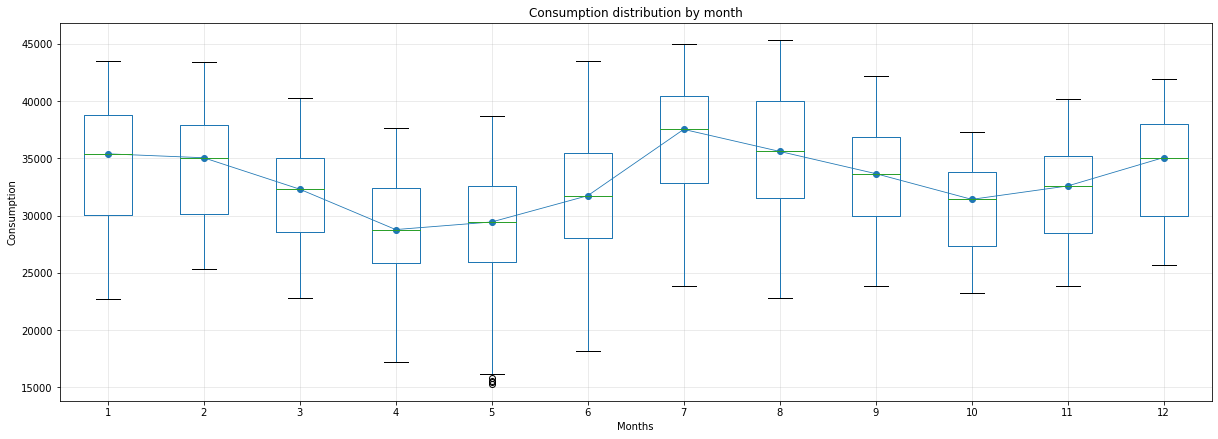

In [15]:
df_monthly_boxplot = df.copy()

fig, ax = plt.subplots(figsize=(20, 7))
df_monthly_boxplot['month'] = df_monthly_boxplot.index.month
df_monthly_boxplot.boxplot(column='value', by='month', ax=ax)
df_monthly_boxplot.groupby('month')['value'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Consumption')
ax.set_xlabel('Months')
ax.set_title('Consumption distribution by month')
fig.suptitle('');
plt.grid(alpha=0.3)

The monthly boxplot shows again the seasonality of the series. We can see that we have a very low quantity of outliers on that sample, that ocurred around May. Those outliers on the lower side of the distribuiton could be some shortage of energy (blackout) that occured in that month in some areas?

This is a phenomenon that we could investigate more if we had enought time. We could even try to model the blackout problem itself if we had enough data to understand it's ocurrence. Some appliances for a problem like a blackout are: regressors, classificators, clustering and anomaly detection algorithms. I would love to share more of my thoughts on this problem on a future call.

Now, let's take a look on the behaviour weekly.

In [16]:
df_weekly = df.resample('W').agg(['mean'])
df_weekly.columns = df_weekly.columns.droplevel()
print("Number of weeks on the dataset:", df_weekly.shape[0])

Number of weeks on the dataset: 83


We didn't get right the number of weeks, though. Probably because each month have a little more than 4 weeks itself, and those days made a 7 week difference for this dataset.

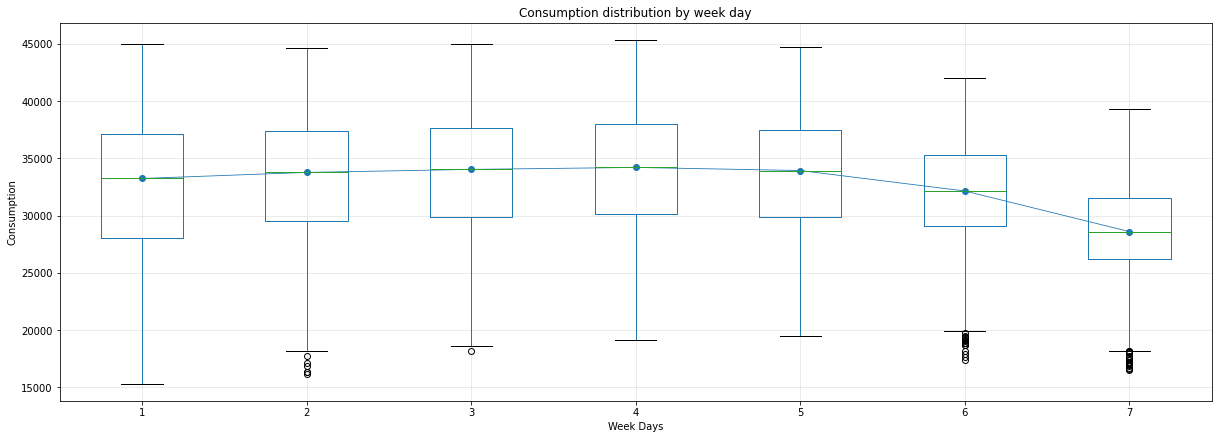

In [17]:
df_weekly_boxplot = df.copy()

fig, ax = plt.subplots(figsize=(20, 7))
df_weekly_boxplot['week_day'] = df_weekly_boxplot.index.day_of_week + 1
df_weekly_boxplot.boxplot(column='value', by='week_day', ax=ax)
df_weekly_boxplot.groupby('week_day')['value'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Consumption')
ax.set_xlabel('Week Days')
ax.set_title('Consumption distribution by week day')
fig.suptitle('');
plt.grid(alpha=0.3)

We can also see that we have some recurrence about the weekly consumption too, being lower at the weekends. Perhaps on the weekends the big comercial centers doesn't work and that reduces energy consumption?

Also, I have a different impression about the outliers on the weekly distribution. I've said that probably the monthly distribution outliers are blackouts, but I don't think that those behave the same way. If we recall the monthly boxplot, we can see that our May outliers are the lowest of the lowest.

Here, in the weekly dataset, we can see that the monday distribution has its minimum and maximum (around 15000 and 45000) covers the others distributions (besides the max value of thursday), even it's outliers.

Then, I assume that those outliers are just days that we had less energy consumption. Having more dense distributed outliers on Saturday and Sunday can also reinforce the ideia of the comercial centers (and other big energy consumers) not working on the weekends.

Now, let's take a look on the behaviour daily.

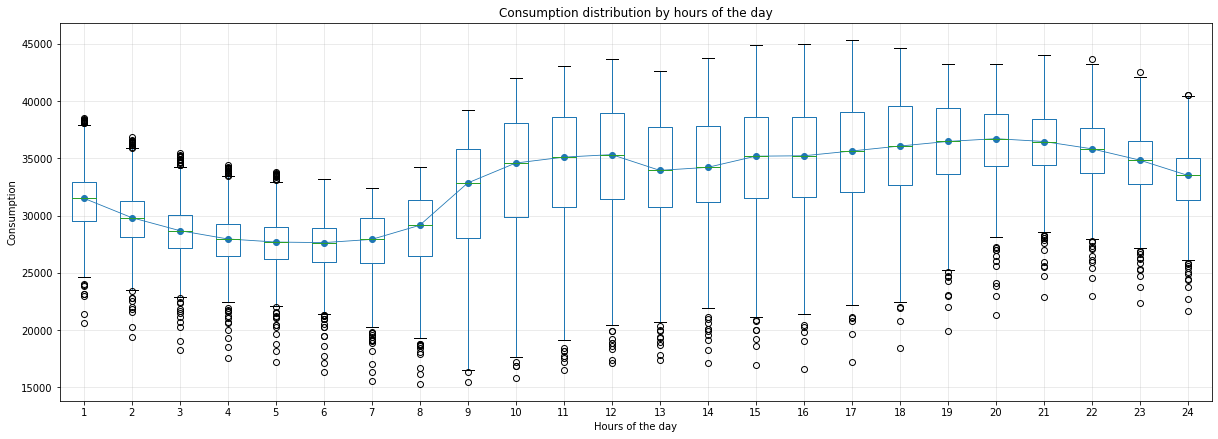

In [18]:
df_daily_boxplot = df.copy()

fig, ax = plt.subplots(figsize=(20, 7))
df_daily_boxplot['hourly'] = df_daily_boxplot.index.hour + 1
df_daily_boxplot.boxplot(column='value', by='hourly', ax=ax)
df_daily_boxplot.groupby('hourly')['value'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Consumption')
ax.set_xlabel('Hours of the day')
ax.set_title('Consumption distribution by hours of the day')
fig.suptitle('');
plt.grid(alpha=0.3)

Thinking about the daily flow of a city, those distribuitions seems pretty reasonable. We have a raise on the consumption by 8am, that goes around until 22pm, usually the working hours of the city's population.

Between 20pm and midnight, we can see a slight drop on the consumption, shifting the corporate area consumption to the night life consumption of pubs and parties, going down until 3-4am, being it's lowest between 5-6am.

---

To finish this analysis, one last visualization that we can make is the monthly and weekly mean by the datetime. Let's see their behaviour to help us awnser seasonality.

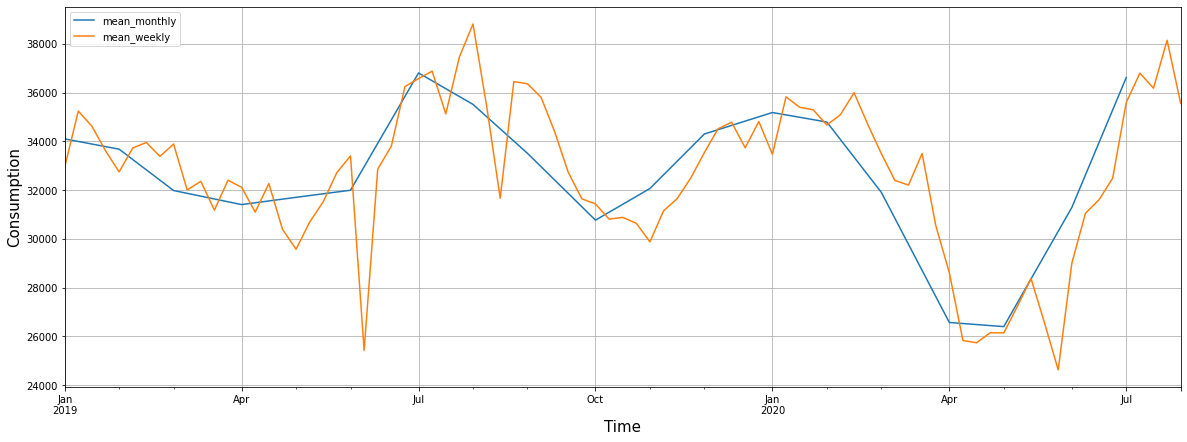

In [19]:
fig, ax = plt.subplots(figsize=(20, 7))
ax.tick_params(axis='both', which='major', labelsize=10)
df_monthly['mean'].plot(label='mean_monthly')
df_weekly['mean'].plot(label='mean_weekly')
plt.ylabel('Consumption', fontsize=15)
plt.xlabel('Time', fontsize=15)
plt.legend()
plt.grid()
plt.show()

Those graphs gave us some intuition about the seasonality of the series, that goes up around July, presents a second peak at the start of the year (christmas eve and new years), then goes down a little in April, just before it rises again in July.


_A business intuition that we can discuss is that: I could guess that probably those data points are not from Rio de Janeiro? I would expect peaks on consumption around november-march, because it's our summer, where we start to use more frequently some heavy load equipments like air conditioners. But who can say? (:_


---



**Some intuition on how the prediction will look like having the information what we've discussed so far**

So, we've got some really strong intuition on how our predictions should look just by concatenating those results we've seen so far.

The last day available on the dataset is 37/07/2020, 23h00. It's a friday. We want to predict the first four hours of the day 01/08/2020, that is a saturday. My intuition is:

* We can see in the monthly boxplot that from July to August we have a energy consumption drop.
* We can see in the weekly boxplot that from friday to saturday we also have a energy consumption drop.
* We can see in the daily boxplot that the hours we want to predict (00am-04am) usualy have a negative slope, so, other energy consumption drop.

My intuition is that our predictions will be leaning towards a negative slope: **a drop in energy consumption.**

Our model will help us understand it more.

---

Let's decompose the time series and see its components. Then, we'll plot it's autocorrelation and partial autocorrelation. This will give us more certainty about our feelings on the seasonality of the series.

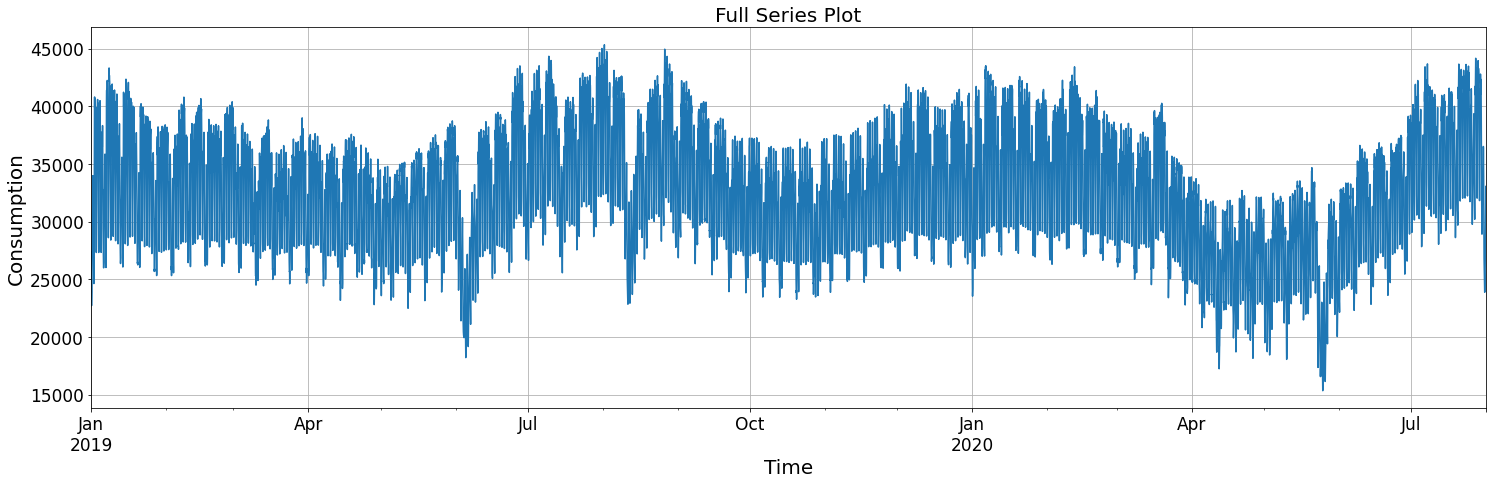

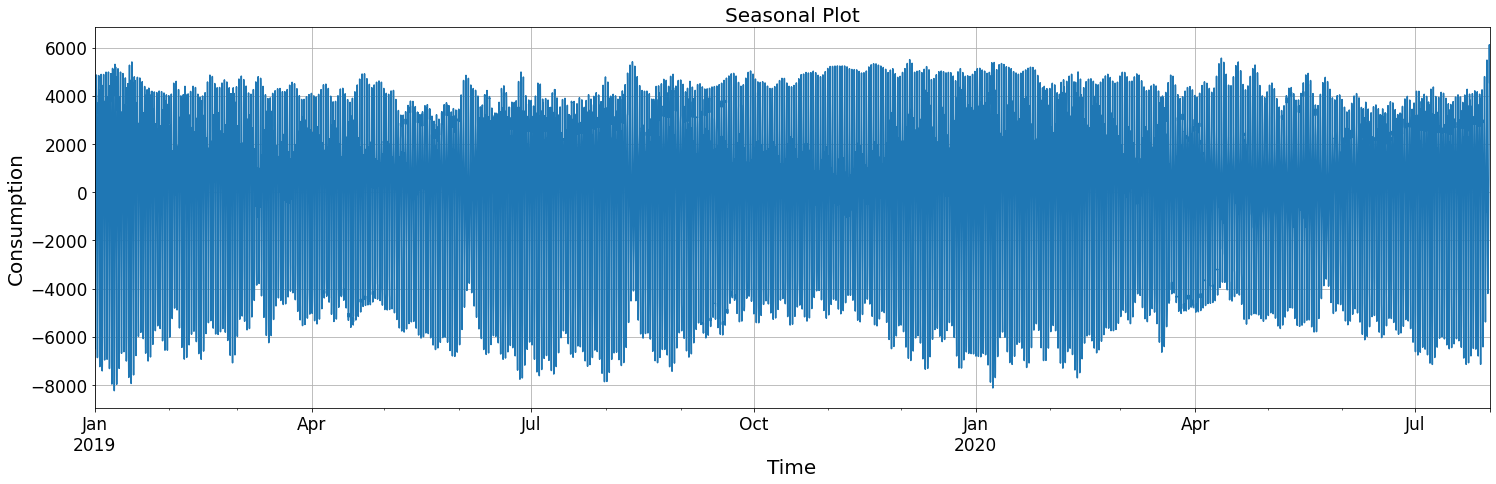

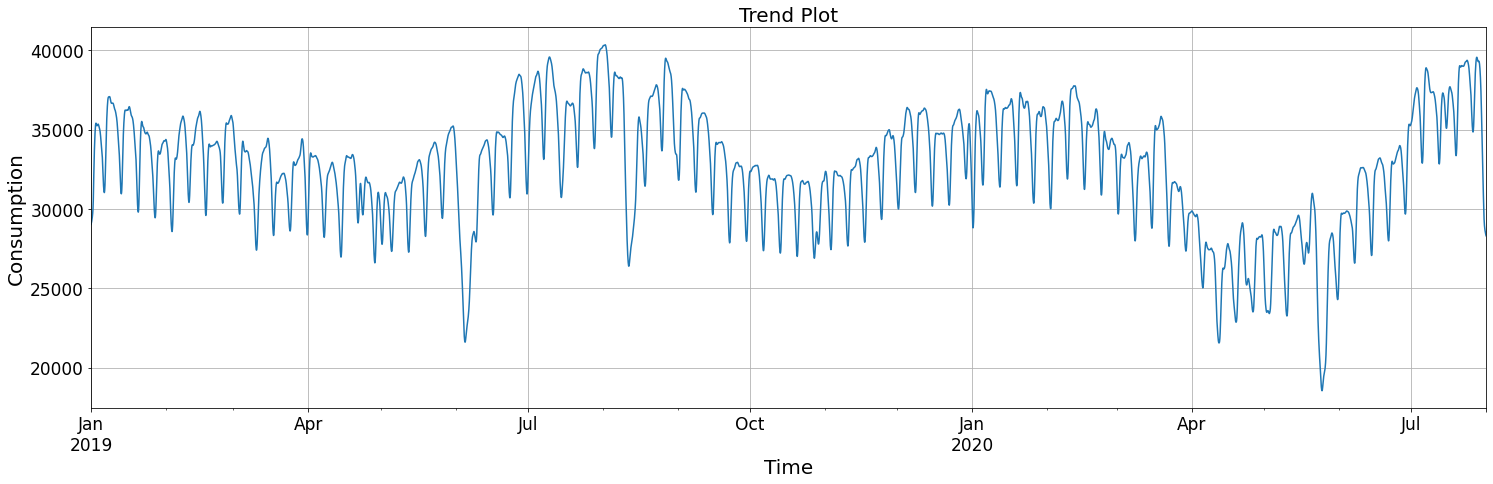

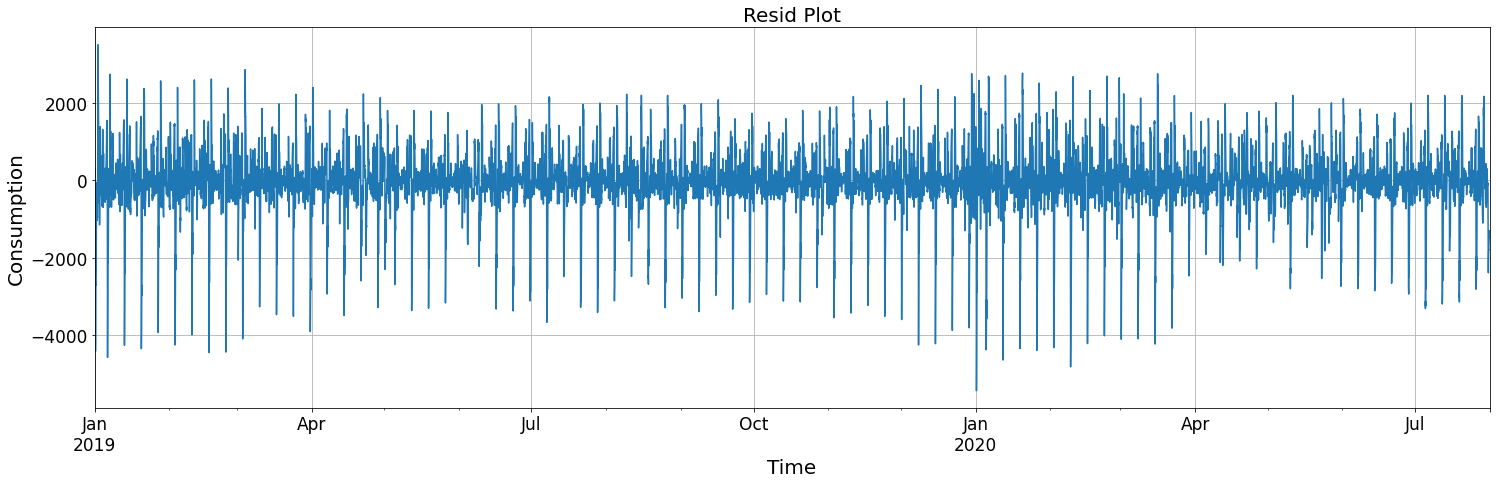

In [20]:
stl = STL(df.value).fit()

fig, ax = plt.subplots(figsize=(25, 7))
ax.tick_params(axis='both', which='major', labelsize=17)
plt.title("Full Series Plot", fontsize=20)
df.value.plot()
plt.ylabel('Consumption', fontsize=20)
plt.xlabel('Time', fontsize=20)
plt.grid()
plt.show()

fig, ax = plt.subplots(figsize=(25, 7))
ax.tick_params(axis='both', which='major', labelsize=17)
plt.title("Seasonal Plot", fontsize=20)
stl.seasonal.plot()
plt.ylabel('Consumption', fontsize=20)
plt.xlabel('Time', fontsize=20)
plt.grid()
plt.show()

fig, ax = plt.subplots(figsize=(25, 7))
ax.tick_params(axis='both', which='major', labelsize=17)
plt.title("Trend Plot", fontsize=20)
stl.trend.plot()
plt.ylabel('Consumption', fontsize=20)
plt.xlabel('Time', fontsize=20)
plt.grid()
plt.show()

fig, ax = plt.subplots(figsize=(25, 7))
ax.tick_params(axis='both', which='major', labelsize=17)
plt.title("Resid Plot", fontsize=20)
stl.resid.plot()
plt.ylabel('Consumption', fontsize=20)
plt.xlabel('Time', fontsize=20)
plt.grid()
plt.show()

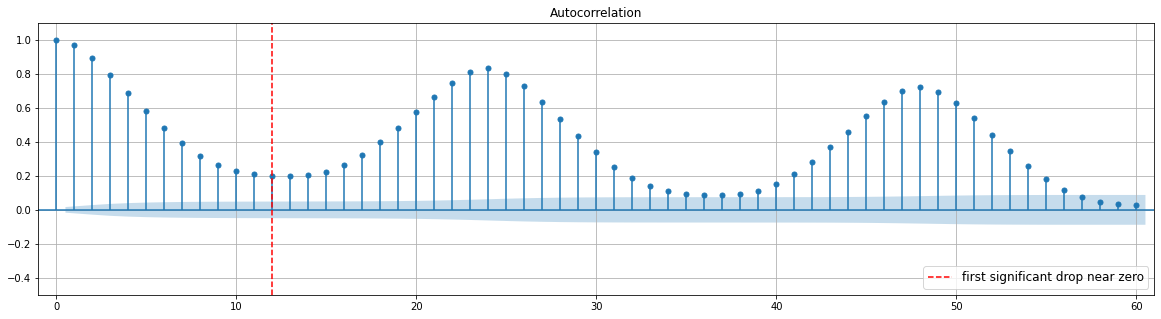

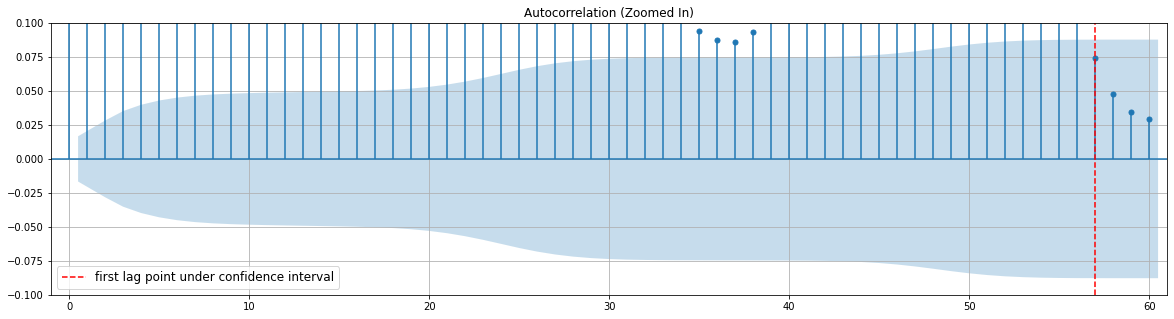

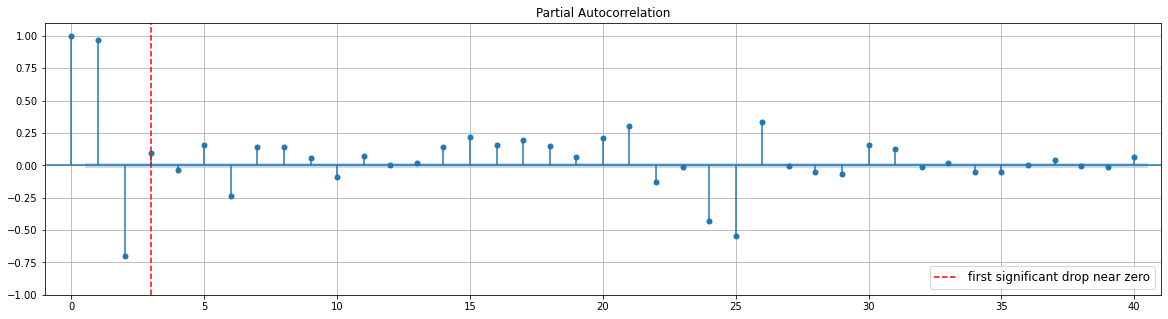

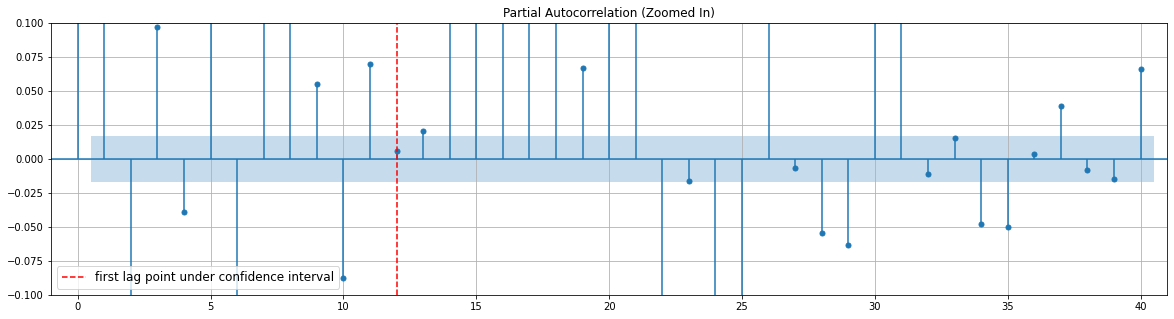

In [21]:
fig, ax = plt.subplots(figsize=(20, 5))
plot_acf(df.value, ax=ax, lags=60)
plt.ylim(-0.5,1.1)
plt.xlim(-1, 61)
plt.axvline(x = 12, linestyle='--', color='red', label='first significant drop near zero')
plt.legend(loc='lower right', fontsize=12)
plt.grid()
plt.show()

fig, ax = plt.subplots(figsize=(20, 5))
plot_acf(df.value, ax=ax, lags=60)
plt.title('Autocorrelation (Zoomed In)')
plt.ylim(-0.1,0.1)
plt.xlim(-1, 61)
plt.axvline(x = 57, linestyle='--', color='red', label='first lag point under confidence interval')
plt.legend(loc='lower left', fontsize=12)
plt.grid()
plt.show()

fig, ax = plt.subplots(figsize=(20, 5))
plot_pacf(df.value, ax=ax, lags=40)
plt.ylim(-1,1.1)
plt.xlim(-1, 41)
plt.axvline(x = 3, linestyle='--', color='red', label='first significant drop near zero')
plt.legend(loc='lower right', fontsize=12)
plt.grid()
plt.show()

fig, ax = plt.subplots(figsize=(20, 5))
plot_pacf(df.value, ax=ax, lags=40)
plt.title('Partial Autocorrelation (Zoomed In)')
plt.ylim(-0.1,0.1)
plt.xlim(-1, 41)
plt.axvline(x = 12, linestyle='--', color='red', label='first lag point under confidence interval')
plt.legend(loc='lower left', fontsize=12)
plt.grid()
plt.show()

The behavior of the autocorrelation lags shows again a small seasonality pattern of the time series, as we had already discussed, confirming it's seasonality.

One last step is to develop the Augmented Dickey-Fuller test to see the stationarity of the series.

In [22]:
statistical_results = adf(df['value'], autolag='AIC')

print('ADFuller results:')
print('Critical value of the data: ', statistical_results[0])
print('H0 will not be rejected (p-value): ', statistical_results[1])
print('Lags used to determine t-statistic:', statistical_results[2])
print('Observations made on the analysis: ', statistical_results[3])
print('T values for adfuller test (dict):', statistical_results[4])



ADFuller results:
Critical value of the data:  -6.724626362340205
H0 will not be rejected (p-value):  3.414341879321089e-09
Lags used to determine t-statistic: 42
Observations made on the analysis:  13829
T values for adfuller test (dict): {'1%': -3.4308229564134334, '5%': -2.8617490249748765, '10%': -2.566881259174479}


The test shows us that our series is **already stationary**. The interpretation of the results are made comparing the critical value of the data with the T values for the adfuller test. We have:

$$-6.7246 < \{-3.4308, -2.8617, -2.5668\}$$

The smaller the critical value is, the more it means we can reject the null hypothesis that our series is non-stationary. Also, our p-value is very close to zero. Then, with $H_0$ rejected, we can accept the alternate hypothesis $H_a$, and say that our series is stationary.

---


### Modelling an Autoregressive Integrated Moving Average Model (ARIMA)

In this portion of the notebook we'll model the data and predict/forecast the energy consumption for hours in advance.

What we'll be doing:

* Applying the ```diff``` function to create differentiations of our time series.
* Analyzing p (ar), d (diff) an q (ma) using ```statsmodels``` functions: ```acf``` and ```pacf```.
    * p (ar): autoregressive.
    * q (ma): moving average.
    * Use the autocorrelation function (ACF) and partial autocorrelation function (PACF) to choose model parameters.
* Developing a autoregressive ARIMA model.
* Estimating error.
* Predicting the next 4 data points.

---

First, in the next cell we'll make all the imports needed to this section.


In [23]:
import datetime

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.simplefilter('ignore', ValueWarning)

from sklearn.metrics import mean_squared_error

Now, we'll differentiate by 1 our time series. Then, our parameter ```d = 1```.

In [24]:
df_diff = df.copy()
df_diff['diff_value'] = df_diff['value'].diff()
df_diff.dropna(inplace = True)
df_diff.head()

,value,diff_value
datetime,,
2019-01-01 01:00:00,26012.17,-1387.47
2019-01-01 02:00:00,24548.73,-1463.44
2019-01-01 03:00:00,23446.89,-1101.84
2019-01-01 04:00:00,22850.35,-596.54
2019-01-01 05:00:00,22714.09,-136.26


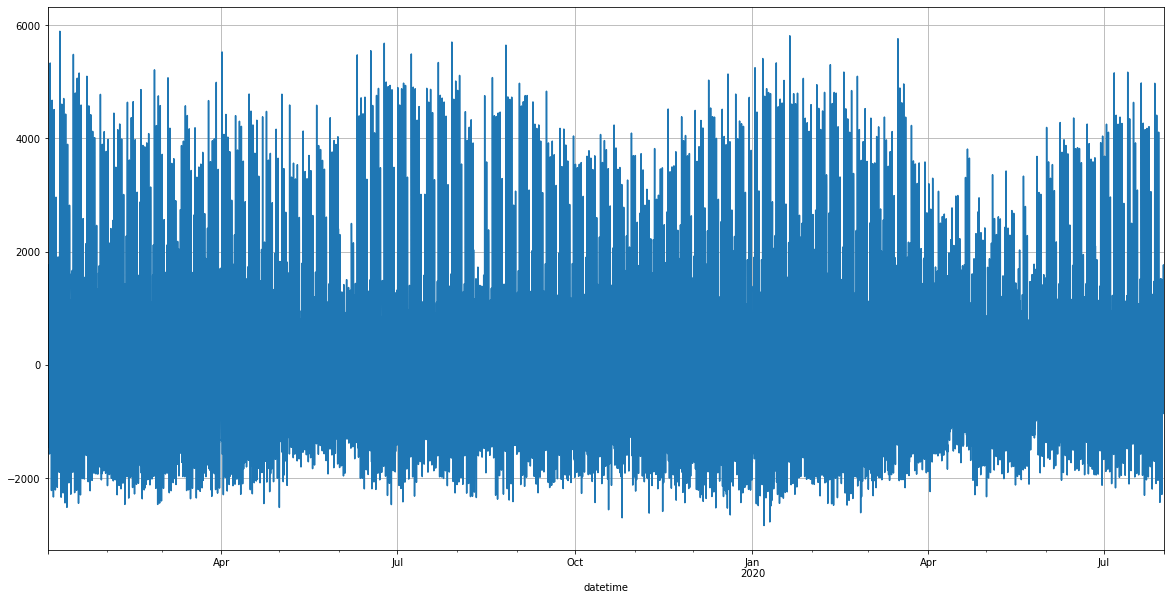

In [25]:
df_diff['diff_value'].plot(figsize=(20,10), grid="on");

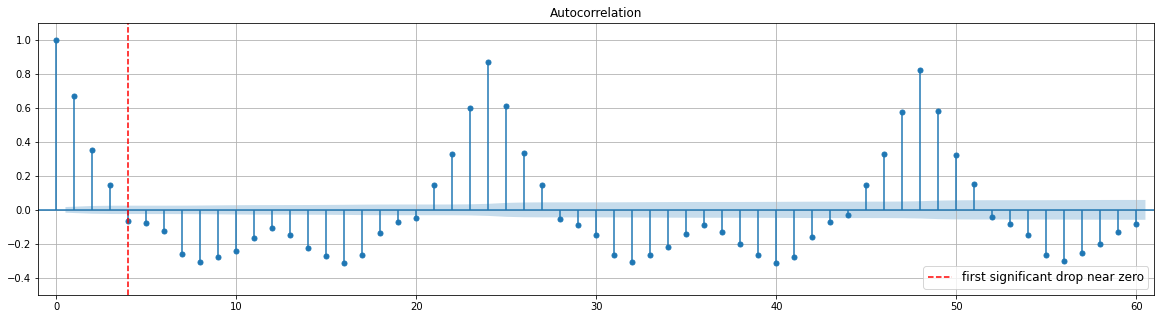

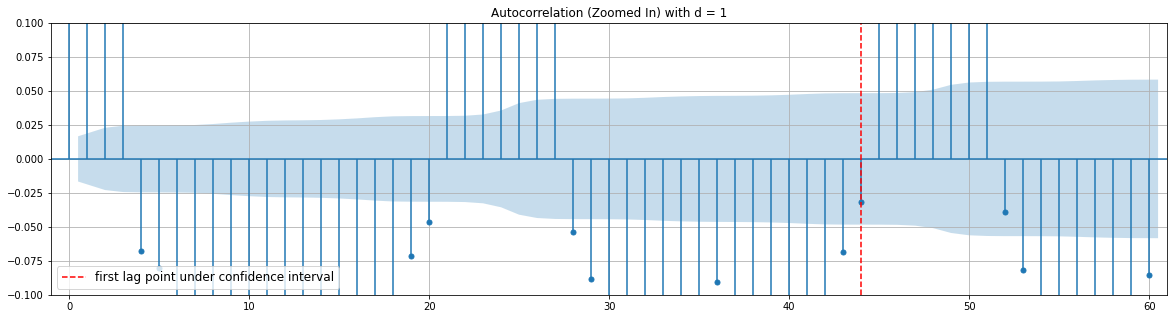

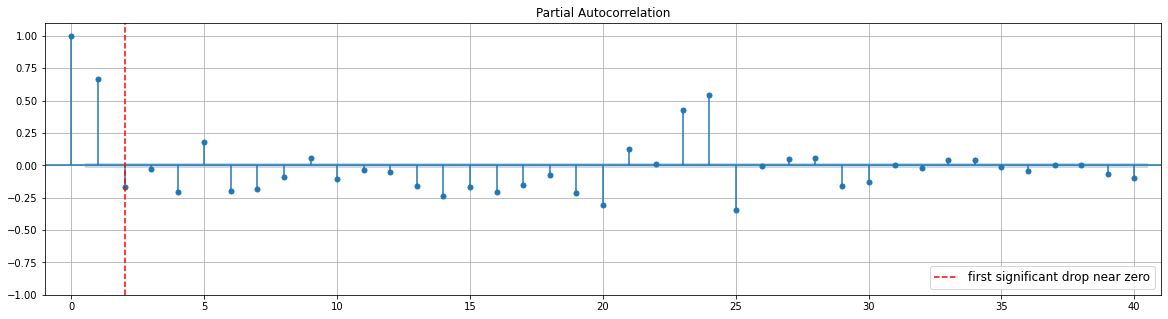

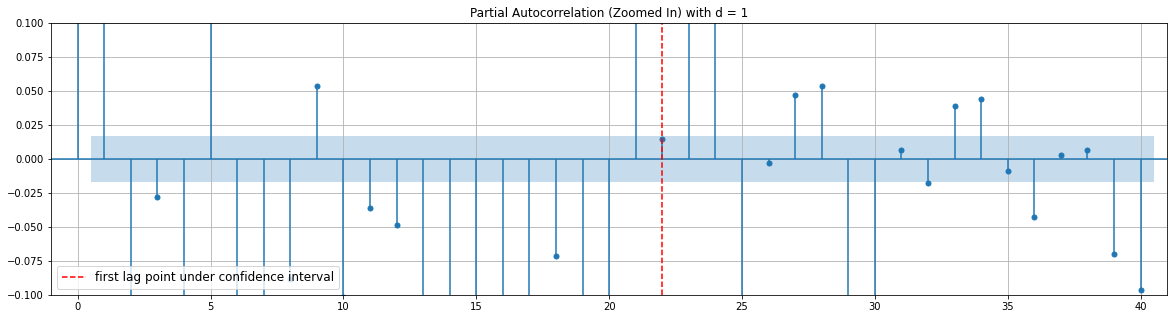

In [26]:
fig, ax = plt.subplots(figsize=(20, 5))
plot_acf(df_diff['diff_value'], ax=ax, lags=60)
plt.ylim(-0.5,1.1)
plt.xlim(-1, 61)
plt.axvline(x = 4, linestyle='--', color='red', label='first significant drop near zero')
plt.legend(loc='lower right', fontsize=12)
plt.grid()
plt.show()

fig, ax = plt.subplots(figsize=(20, 5))
plot_acf(df_diff['diff_value'], ax=ax, lags=60)
plt.title('Autocorrelation (Zoomed In) with d = 1')
plt.ylim(-0.1,0.1)
plt.xlim(-1, 61)
plt.axvline(x = 44, linestyle='--', color='red', label='first lag point under confidence interval')
plt.legend(loc='lower left', fontsize=12)
plt.grid()
plt.show()

fig, ax = plt.subplots(figsize=(20, 5))
plot_pacf(df_diff['diff_value'], ax=ax, lags=40)
plt.ylim(-1,1.1)
plt.xlim(-1, 41)
plt.axvline(x = 2, linestyle='--', color='red', label='first significant drop near zero')
plt.legend(loc='lower right', fontsize=12)
plt.grid()
plt.show()

fig, ax = plt.subplots(figsize=(20, 5))
plot_pacf(df_diff['diff_value'], ax=ax, lags=40)
plt.title('Partial Autocorrelation (Zoomed In) with d = 1')
plt.ylim(-0.1,0.1)
plt.xlim(-1, 41)
plt.axvline(x = 22, linestyle='--', color='red', label='first lag point under confidence interval')
plt.legend(loc='lower left', fontsize=12)
plt.grid()
plt.show()

I still dont think that the results on the autocorrelation and partial autocorrelationon are good enough because we still have ```p``` and ```d``` values that are too large. So, I'll perform another differentiation. Now, our parameter ```d = 2```.

In [27]:
df_diff2 = df.copy()
df_diff2['diff_value'] = df_diff['value'].diff().diff()
df_diff2.dropna(inplace = True)
df_diff2.head()

,value,diff_value
datetime,,
2019-01-01 03:00:00,23446.89,361.60
2019-01-01 04:00:00,22850.35,505.30
2019-01-01 05:00:00,22714.09,460.28
2019-01-01 06:00:00,23106.73,528.90
2019-01-01 07:00:00,23575.76,76.39


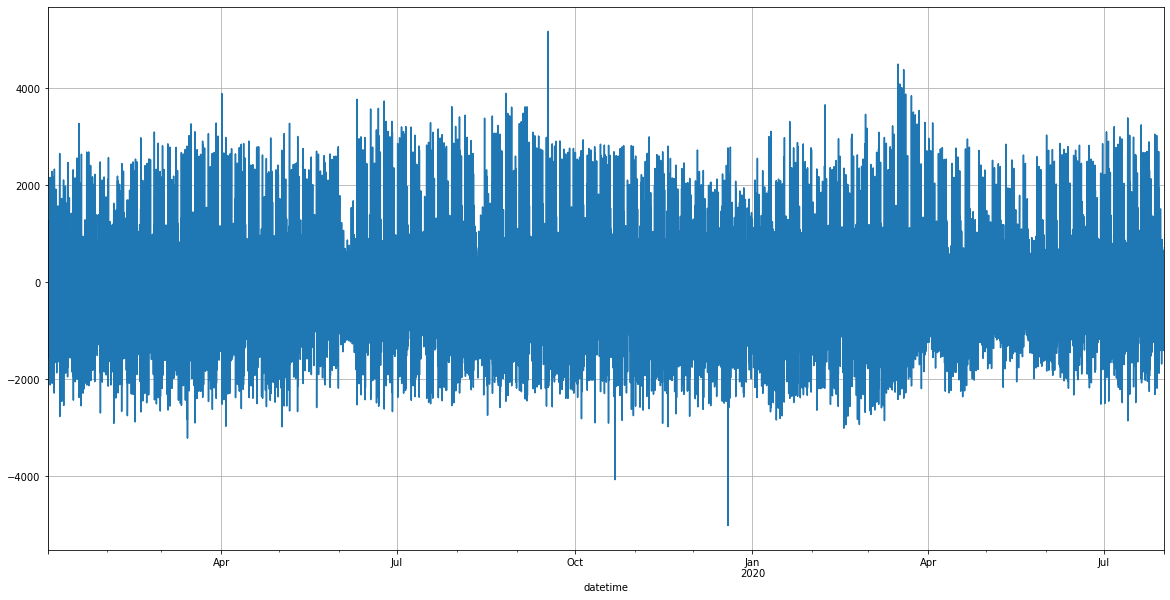

In [28]:
df_diff2['diff_value'].plot(figsize=(20,10), grid="on");

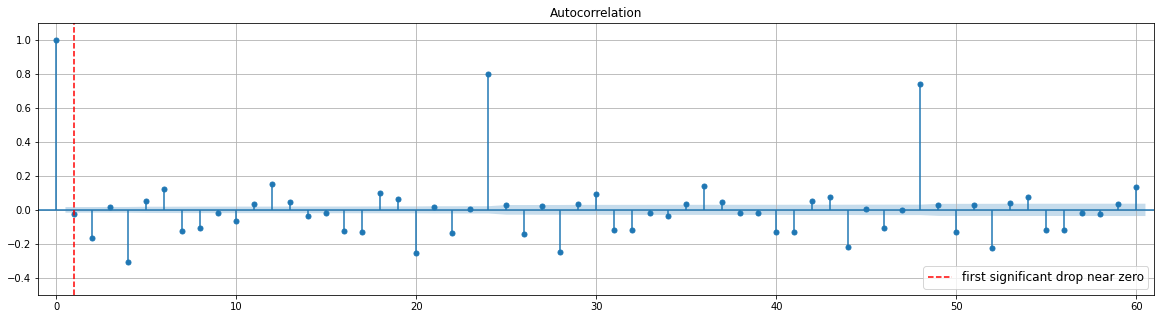

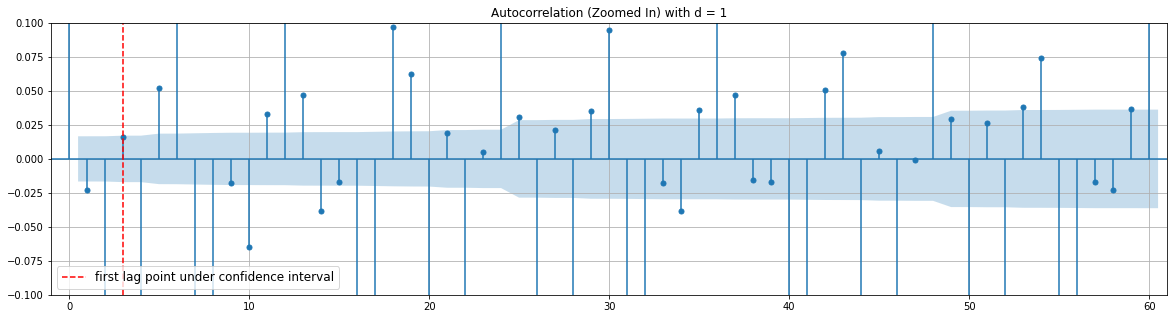

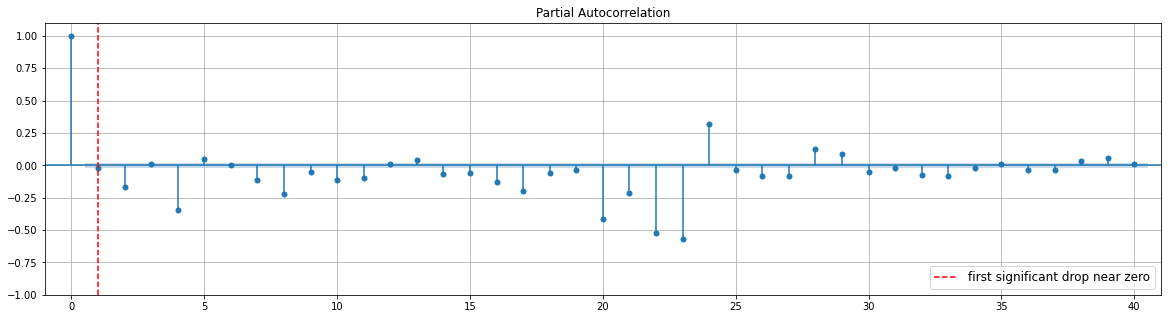

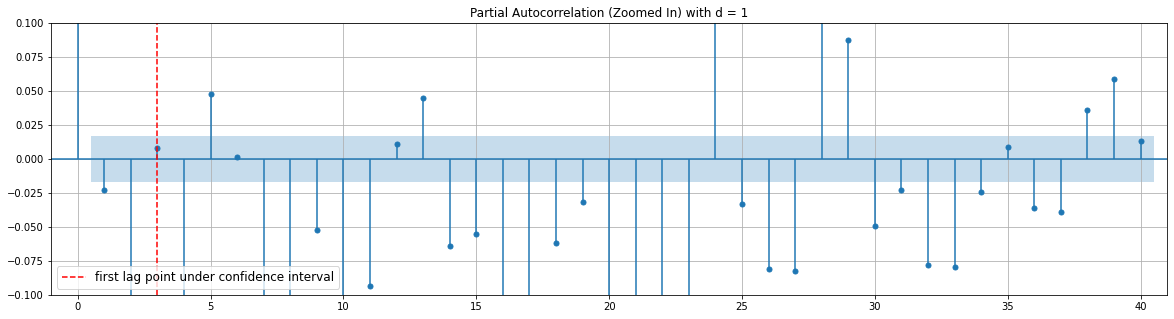

In [29]:
fig, ax = plt.subplots(figsize=(20, 5))
plot_acf(df_diff2['diff_value'], ax=ax, lags=60)
plt.ylim(-0.5,1.1)
plt.xlim(-1, 61)
plt.axvline(x = 1, linestyle='--', color='red', label='first significant drop near zero')
plt.legend(loc='lower right', fontsize=12)
plt.grid()
plt.show()

fig, ax = plt.subplots(figsize=(20, 5))
plot_acf(df_diff2['diff_value'], ax=ax, lags=60)
plt.title('Autocorrelation (Zoomed In) with d = 1')
plt.ylim(-0.1,0.1)
plt.xlim(-1, 61)
plt.axvline(x = 3, linestyle='--', color='red', label='first lag point under confidence interval')
plt.legend(loc='lower left', fontsize=12)
plt.grid()
plt.show()

fig, ax = plt.subplots(figsize=(20, 5))
plot_pacf(df_diff2['diff_value'], ax=ax, lags=40)
plt.ylim(-1,1.1)
plt.xlim(-1, 41)
plt.axvline(x = 1, linestyle='--', color='red', label='first significant drop near zero')
plt.legend(loc='lower right', fontsize=12)
plt.grid()
plt.show()

fig, ax = plt.subplots(figsize=(20, 5))
plot_pacf(df_diff2['diff_value'], ax=ax, lags=40)
plt.title('Partial Autocorrelation (Zoomed In) with d = 1')
plt.ylim(-0.1,0.1)
plt.xlim(-1, 41)
plt.axvline(x = 3, linestyle='--', color='red', label='first lag point under confidence interval')
plt.legend(loc='lower left', fontsize=12)
plt.grid()
plt.show()

With ```d = 2```, we've found good points for ar and ma, both being one (```p = q = 1```). We'll try to train the model with those parameters to understand its performance.

---

We'll instantiate the ARIMA model and then execute the ```fit``` method.

In [30]:
model = ARIMA(df, order=(1,2,1))
model_fit = model.fit()

Then, we'll forecast on the series itself.

In [31]:
start_index = datetime.datetime(2019, 1, 1)
end_index = datetime.datetime(2020, 8, 1)
forecast = model_fit.predict(start=start_index, end=end_index)

I've opted to train the model with the totality of the data and not to split between train and testing sets, knowing that could cause some overfit on my model. I'll also perform my RMSE metric on the whole timeseries.

Something I would like to do if I had enought time to was to split around 70/30 my train and test sets. I would take care with the time characteristics of the data to not shuffle them. Then, I would, for each prediction made, compare it to the the real value and then refit the model, sliding this window until the refit covers the totality of the test set (backtesting). 

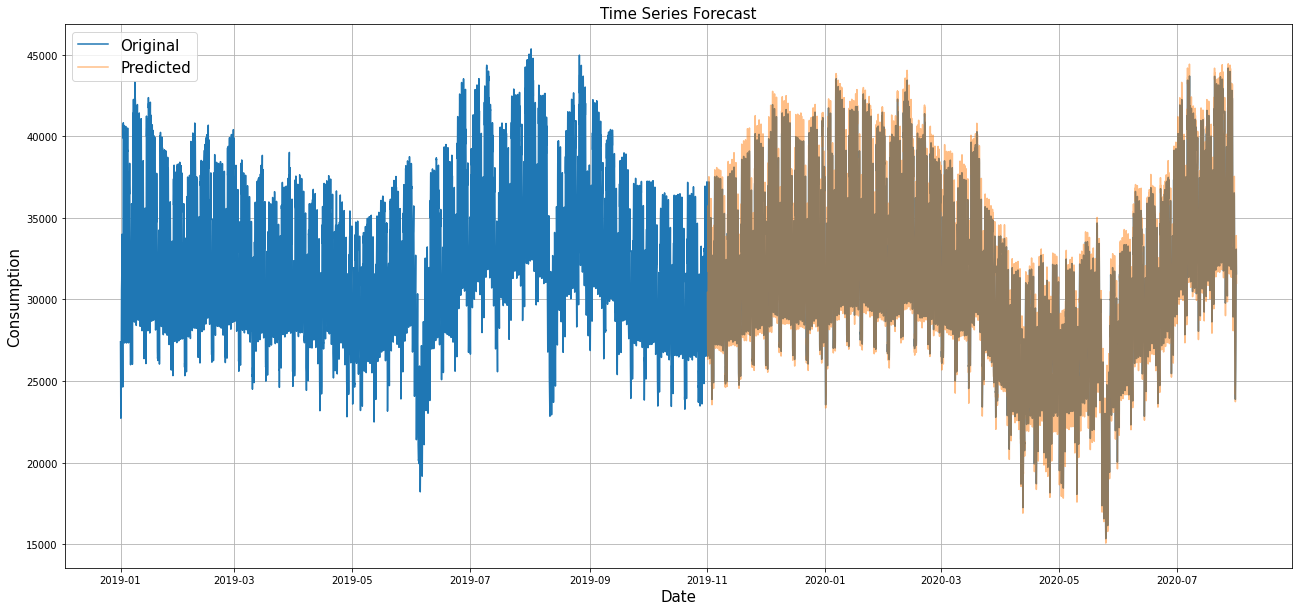

In [32]:
plt.figure(figsize=(22,10))
plt.plot(df, label="Original")
plt.plot(forecast['2019-11':], label = "Predicted", alpha=0.5)
plt.title("Time Series Forecast", fontsize=15)
plt.xlabel("Date", fontsize=15)
plt.ylabel("Consumption", fontsize=15)
plt.legend(fontsize=15)
plt.grid()
plt.show()

In [33]:
rmse = mean_squared_error(df['value'], forecast[1:], squared=False)
print(f'The RMSE for the model above is: {rmse:.2f}')

The RMSE for the model above is: 886.38


The RMSE is very low for the scale of the data, which may indicate a slight overfit of our model. We'll continue our analysis and predictions with this model, because the next part of the analysis will compare various models and their metrics.

Visually, we can see that it adapts very well! Let's try to predict the first day of August!

In [34]:
start_index = datetime.datetime(2020, 8, 1)
end_index = datetime.datetime(2020, 8, 2)
forecast = model_fit.predict(start=start_index, end=end_index)

Here, we have the full day! To access the **awnser to the problem**, we get the first four samples:

In [35]:
forecast[0:4]

2020-08-01 00:00:00    30990.586918
2020-08-01 01:00:00    30605.151148
2020-08-01 02:00:00    30347.148515
2020-08-01 03:00:00    30174.594100
Freq: H, Name: predicted_mean, dtype: float64

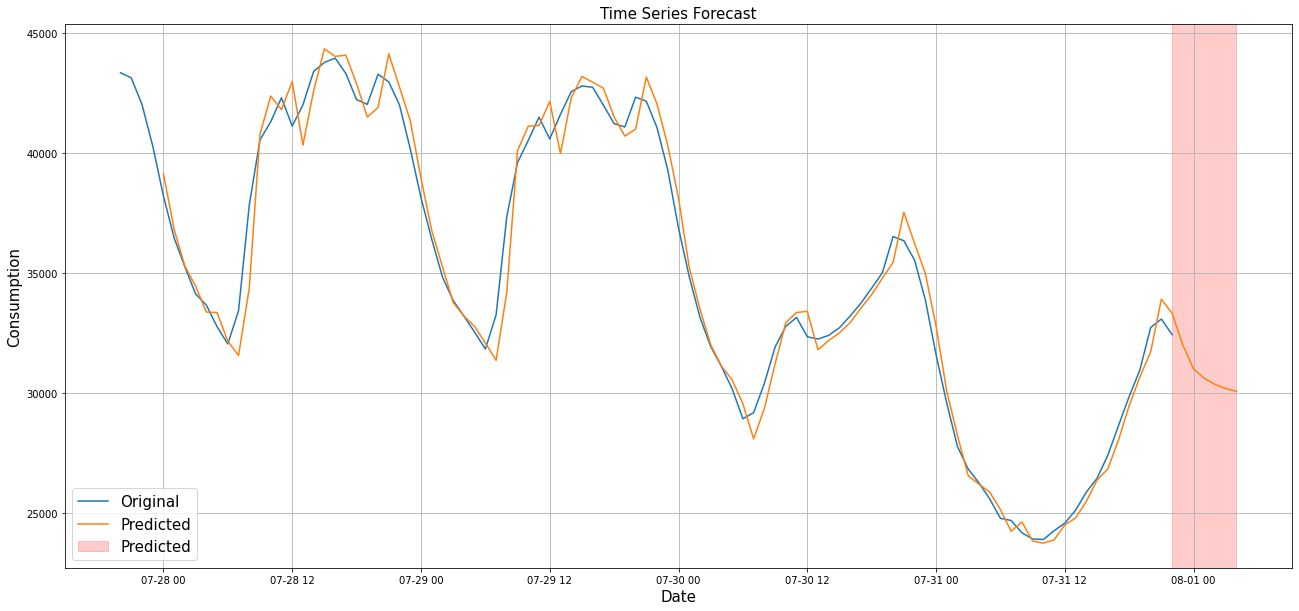

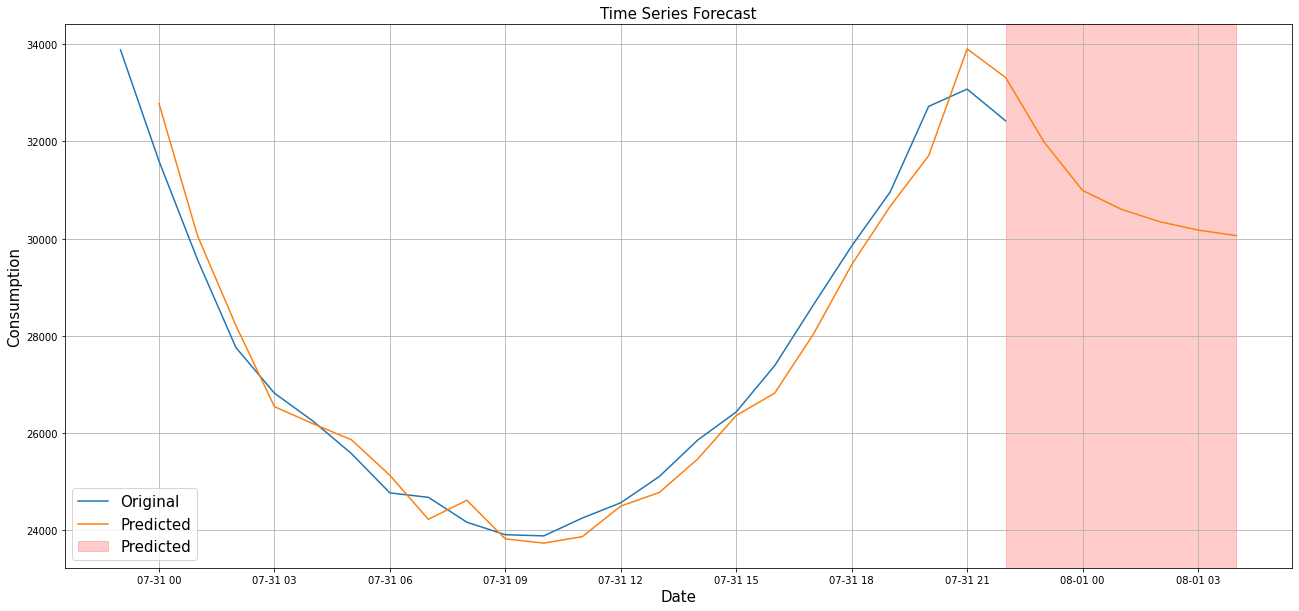

In [36]:
df_final_plot = df.iloc[-100:-1]

start_index = datetime.datetime(2020, 7, 28)
end_index = datetime.datetime(2020, 8, 1, 4)
forecast = model_fit.predict(start=start_index, end=end_index)

plt.figure(figsize=(22,10))
plt.plot(df_final_plot, label="Original")
plt.plot(forecast, label = "Predicted")
plt.title("Time Series Forecast", fontsize=15)
plt.xlabel("Date", fontsize=15)
plt.ylabel("Consumption", fontsize=15)
plt.axvspan(xmin=datetime.datetime(2020, 7, 31, 22), xmax=datetime.datetime(2020, 8, 1, 4), color='red', alpha=0.2, label='Predicted')
plt.legend(fontsize=15)
plt.grid()
plt.show()

df_final_plot = df.iloc[-25:-1]

start_index = datetime.datetime(2020, 7, 31)
end_index = datetime.datetime(2020, 8, 1, 4)
forecast = model_fit.predict(start=start_index, end=end_index)

plt.figure(figsize=(22,10))
plt.plot(df_final_plot, label="Original")
plt.plot(forecast, label = "Predicted")
plt.title("Time Series Forecast", fontsize=15)
plt.xlabel("Date", fontsize=15)
plt.ylabel("Consumption", fontsize=15)
plt.axvspan(xmin=datetime.datetime(2020, 7, 31, 22), xmax=datetime.datetime(2020, 8, 1, 4), color='red', alpha=0.2, label='Predicted')
plt.legend(fontsize=15)
plt.grid()
plt.show()

We'll see how others models behave with it in the next section, where we'll implement an autoML package to accelerate our development.

### Multiple Models with AutoML

One quick way to implement multiple models in our machine learning pipelines is by using AutoML (automatic machine learning) tools and packages. One free-to-use and reasonably popular AutoML package is PyCaret.

AutoML tools present valuable time-effort relations for Data Scientists to understand how models behave without having to fit each one by hand. I advocate for knowing how to fit and tune each model, which I've shown before, fitting the ARIMA, but using the available tools to save both execution and coding time is a valid approach too.

In this section, we'll use the ```pycaret.time_series``` module to run multiple modules and see their statistics. Then, we'll choose the best model on the array and see its predictions too.

---

First, we'll import the module needed for this part.

In [37]:
from pycaret.time_series import *

Then, we create the setup of our auto ML experiment.

In [38]:
automl_setup = setup(df, fh = 3, fold = 5, session_id = 123)

,Description,Value
0,session_id,123
1,Target,value
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(13872, 1)"
5,Transformed data shape,"(13872, 1)"
6,Transformed train set shape,"(13869, 1)"
7,Transformed test set shape,"(3, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


Then, we can choose some models to compare. Here, we'll compare the following models:

* ARIMA
* Exponential Smoothing
* Naive Forecaster
* Seasonal Naive Forecaster
* Polynomial Trend Forecaster
* Linear Regressor
* Ridge Regressor

In [39]:
auto_ml_models = compare_models(
    ['arima', 'exp_smooth', 'naive', 'snaive', 'polytrend', 'lr_cds_dt', 'ridge_cds_dt'], n_select = 4)

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,0.4701,0.3691,884.9217,1081.3253,0.0349,0.0337,-27.1428,1.7660
ridge_cds_dt,Ridge w/ Cond. Deseasonalize & Detrending,0.4701,0.3691,884.9217,1081.3253,0.0349,0.0337,-27.1428,1.7480
arima,ARIMA,0.6274,0.4430,1181.2885,1297.9888,0.0467,0.0456,-60.0184,2.6320
naive,Naive Forecaster,0.6746,0.4803,1271.0500,1408.2036,0.0453,0.0465,-5.4368,1.0980
exp_smooth,Exponential Smoothing,1.3420,0.9481,2527.8289,2778.7278,0.0946,0.0944,-92.7531,1.2260
polytrend,Polynomial Trend Forecaster,2.8451,1.8428,5356.6962,5398.9849,0.2131,0.1883,-600.8829,0.4400
snaive,Seasonal Naive Forecaster,3.2485,2.0974,6117.8580,6146.1514,0.2377,0.2101,-645.9700,0.7320


Here, we can see that the metrics around the RMSE are more aligned with the consumption scale. This indicates less of a overfit on those models. Plus, the AutoML made the train-test-split with 5 folds using the sk.time ExpandingWindowSplitter to take care of the time behavior, leaving 3 samples to be tested.

In [40]:
auto_ml_models

[BaseCdsDtForecaster(regressor=LinearRegression(n_jobs=-1), sp=24,
                     window_length=24),
 BaseCdsDtForecaster(regressor=Ridge(random_state=123), sp=24, window_length=24),
 ARIMA(seasonal_order=(0, 1, 0, 24)),
 NaiveForecaster()]

Above we have the hyperparameters for our models. Now, let's take the best of them and make the predictions.

In [41]:
best_model = auto_ml_models[0]

In [42]:
final_best = finalize_model(best_model)
predict_model(best_model, fh = 10)

,y_pred
2020-07-31 21:00,33121.2860
2020-07-31 22:00,32539.6725
2020-07-31 23:00,31397.4841
2020-08-01 00:00,29596.8684
2020-08-01 01:00,27890.1494
2020-08-01 02:00,26775.0275
2020-08-01 03:00,25913.7341
2020-08-01 04:00,25576.9384
2020-08-01 05:00,25081.5450
2020-08-01 06:00,24798.8218


And that's the 10 next predictions for the best model found by the Auto ML process.

### Results and final considerations

We've developed a data preparation, analysis and modelling for the given question. Remembering our results:

For the ARIMA model we've fitted manually, we've got the following 4 predictions for the first day of August:

|Datetime|Predictions|
|--------|-----------|
|2020-08-01 00:00:00|30990.586918|
|2020-08-01 01:00:00|30605.151148|
|2020-08-01 02:00:00|30347.148515|
|2020-08-01 03:00:00|30174.594100|

For the Linear Regressor w/ Cond. Deseasonalize & Detrending, that won the Auto ML processes, we've got the following 4 predicitions for the first day of August

|Datetime|Predictions|
|--------|-----------|
|2020-08-01 00:00:00|29596.8684|
|2020-08-01 01:00:00|27890.1494|
|2020-08-01 02:00:00|26775.0275|
|2020-08-01 03:00:00|25913.7341|

We can see that the ARIMA model took the predictions slowly, with a smaller general slope and the Linear Regressor got more agressive with this parameter. **But, both of them predict a fall on consumption levels by the start of August** and this confirms our intuition made on the EDA.



By comparing the RMSE, the Linear Regressor should do a better job at predicting this time series.


And thats it!

---

Hope you've enjoyed reading through this test as much as I liked developing it!

Best regards!